We are going to do some optimization inspired by bumblebee route finding. Bumblebees are known to repeatedly visit flowers (or experimenter-positioned sugar-water feeders). Their routes improve over successive flights such that they visit more flowers with less flying.

To complete this problem set, remember a few things:

- the `np.argmin` function
- the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) to measure [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The locations of the nest and several feeders are given in meters in [X,Y] pairs.
locations = {'nest':[0, 0], 'A': [32.3, 21.2], 'B': [29.1, 19.1],
             'C': [0.2, 29.1], 'D': [-2.2, 20.1], 'E':[32.2, 32.1],
             'F':[33.8, 31.8],
            }

(-4.0, 35.599999999999994, -1.6050000000000002, 33.705)

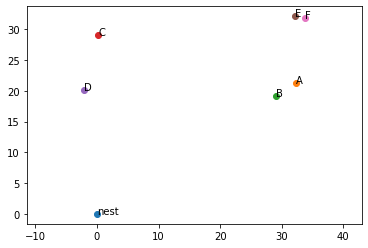

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for key in locations:
    ax.plot( [locations[key][0]], [locations[key][1]], 'o' )
    ax.text( locations[key][0], locations[key][1], key )
ax.axis('equal')

## Q1 Define a function to compute distance between two locations.

Define a distance function that takes two (x,y) coordinates and returns the Euclidean distance between these coordinates. Call this function `my_distance`. You will need to use the Pythagorean theorem.

In [4]:
# Enter code here
def my_distance(a,b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum((a-b)**2))

In [5]:
# Do not change this, this is a test of the above code
assert(my_distance([0.0, 0.0], [0.0, 5.0])==5)
assert(my_distance((0,0), (5,0))==5)
assert(my_distance((0,3), (4,0))==5)
assert(my_distance((1,3), (5,0))==5)
assert(my_distance((1,4), (5,1))==5)
assert(my_distance((1,2), (5,-1))==5)

Now we will compute the distances between every pair of locations.

In [6]:
keys = list(locations.keys())

distances_dict = {}
for i in range(len(keys)):
    for j in range(len(keys)):
        key_i = keys[i]
        key_j = keys[j]
        this_distance = my_distance(locations[key_i], locations[key_j])
        if key_i not in distances_dict:
            distances_dict[key_i] = {}
        distances_dict[key_i][key_j] = this_distance

Note, the above dictionary-of-dictionaries is perhaps easy to understand and keeps the labels (e.g. `'nest'` and `'A'`) with the data, but it is more common to store distances in a "distance matrix". Here we create and plot the distance matrix.

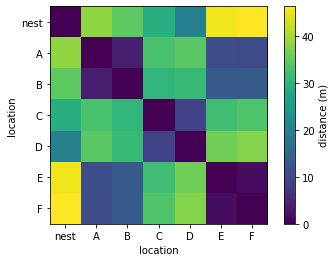

In [7]:
distances_arr = np.zeros((len(keys), len(keys)))
keys = list(locations.keys())
for i in range(len(keys)):
    for j in range(len(keys)):
        key_i = keys[i]
        key_j = keys[j]
        distances_arr[i,j] = distances_dict[key_i][key_j]

fig, ax = plt.subplots(nrows=1, ncols=1)
cmap = ax.imshow(distances_arr,interpolation='nearest')
cax = fig.colorbar(cmap)
cax.set_label("distance (m)")

ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys)
ax.set_xlabel("location")

ax.set_yticks(range(len(keys)))
ax.set_yticklabels(keys)
ax.set_ylabel("location");

## Q2 What is the total distance from the nest to feeder A to feeder B? Put this in a variable `distance_nest_a_b`

In [8]:
# Enter code here
distance_nest_a_b = distances_dict['nest']['A'] + distances_dict['A']['B']
print(distance_nest_a_b)

42.4633960096955


In [9]:
# Do not change this, this is a test of the above code
assert(abs(distance_nest_a_b-42.4633960096955) < 1e-5)

In [10]:
def all_possible_sequences(locs):
    '''given an input series `locs`, return all possible ordered sequences
    
    >>> all_possible_sequences((1,2,3))
    [(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]
    '''
    n = len(locs)
    answers = []
    if n== 1:
        answers.append(tuple(locs))
        return answers    
    for i in range(n):
        not_i = list(locs)
        del not_i[i]
        not_i_orderings = all_possible_sequences(not_i)
        for not_i_ordering in not_i_orderings:
            this_order = [locs[i]] + list(not_i_ordering)
            answers.append(tuple(this_order))
    return answers

# The next lines check that the example in the docstring is correct.
import doctest
doctest.testmod();

In [11]:
feeders = list(locations.keys())
feeders.remove('nest')
print(feeders)

['A', 'B', 'C', 'D', 'E', 'F']


In [12]:
orderings = all_possible_sequences(feeders)

In [13]:
print(len(orderings))

720


Now, let's also include starting and stopping at the nest. A bumblebee that doesn't manage this is no good to the hive.

In [14]:
new_orderings = []
for ordering in orderings:
    new_orderings.append( tuple( ['nest'] + list(ordering) + ['nest'] ) )

In [15]:
print(new_orderings[0])

('nest', 'A', 'B', 'C', 'D', 'E', 'F', 'nest')


We are going to compute the total ("cumulative") distance of all possible flights that leave the nest, visit all feeders, and return to the nest. First, we define a function which will compute this cumulative distance for a particular sequence.

In [16]:
def compute_cumulative_distance(seq, dists):
    """given an ordering in `seq` and distances in `dists`, compute the cumulative sequence distance
    
    >>> dist_dict = {'x':{'y':1.0,'z':0.5}, 'y':{'x':1.0,'z':1.1}, 'z':{'x':0.5, 'y': 1.1}}
    >>> compute_cumulative_distance(['x','y','z'], dist_dict)
    2.1
    """
    accum = 0.0
    for i in range(len(seq)-1):
        start_loc = seq[i]
        stop_loc = seq[i+1]
        this_dist = dists[start_loc][stop_loc]
        accum += this_dist
    return accum

# The next lines check that the example in the docstring is correct.
import doctest
doctest.testmod();

Now, we are going to run our function for all possible sequences and store the results in `path_lengths`.

In [17]:
path_lengths = []
for ordering in new_orderings:
    path_lengths.append(compute_cumulative_distance(ordering, distances_dict))

## Q3 What is the shortest distance possible for the bee to fly while still visiting all flowers after leaving the nest and then returning again at the end.

What is the shortest path for the bee to visit all flowers? Hint: remember `np.argmin`.

This is the famous [traveling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Place the distance travelled in the shortest route in the variable `shortest_path`.
Place this sequence in the variable `shortest_sequence`.

In [18]:
# Enter code here
idx_of_shortest = np.argmin(path_lengths)
shortest_path = path_lengths[idx_of_shortest]
shortest_sequence = new_orderings[idx_of_shortest]
print(shortest_path)
print(shortest_sequence)

112.64421398776797
('nest', 'B', 'A', 'F', 'E', 'C', 'D', 'nest')


In [19]:
# Do not change this, this is a test of the above code
assert(abs(shortest_path-112.64421398776797)<1e-6)
assert(shortest_sequence==('nest', 'B', 'A', 'F', 'E', 'C', 'D', 'nest'))

## Q4 What is the average distance of all paths which left the nest and visited all feeders exactly once?

Put this in a variable `average_path_length`.

In [20]:
# Enter code here
average_path_length = np.mean(path_lengths)
print(average_path_length)

182.5098741313341


In [21]:
# Do not change this, this is a test of the above code
assert(abs(average_path_length-182.5098741313341)<1e-6)

## Q5 (challenging) All the above again, slightly modified

If the bumblebee could satisfy her hive's needs with only 4 feeder visits, what would be the route that she should follow to have the shortest nest-4 feeders-nest sequence (place this in the variable `shortest_sequence_4`)? How long would that path be (place this in the variable `shortest_path_4`)?

In [22]:
# Enter code here
short_orderings = {}
for ordering in orderings:
    short_orderings[ tuple( ['nest'] + list(ordering[:4]) + ['nest'] ) ] = None
short_orderings = list(short_orderings.keys())
print("len(short_orderings)",len(short_orderings))

path_lengths_4 = []
for ordering in short_orderings:
    path_lengths_4.append(compute_cumulative_distance(ordering, distances_dict))

idx_of_shortest = np.argmin(path_lengths_4)
shortest_path_4 = path_lengths_4[idx_of_shortest]
shortest_sequence_4 = short_orderings[idx_of_shortest]
print(shortest_path_4)
print(shortest_sequence_4)

len(short_orderings) 360
96.43637326052391
('nest', 'B', 'A', 'F', 'E', 'nest')


In [23]:
# Do not change this, this is a test of the above code
assert(abs(shortest_path_4-96.43637326052391)<1e-6)
assert(shortest_sequence_4==('nest', 'B', 'A', 'F', 'E', 'nest'))

(-4.0, 35.599999999999994, -1.6050000000000002, 33.705)

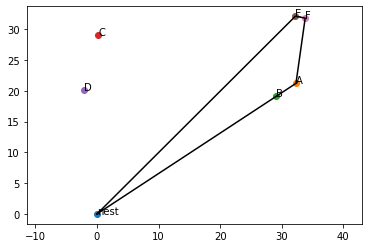

In [24]:
# Now, let's look at the result.
fig, ax = plt.subplots(nrows=1, ncols=1)
for key in locations:
    ax.plot( [locations[key][0]], [locations[key][1]], 'o' )
    ax.text( locations[key][0], locations[key][1], key )
    
xx = []
yy = []
for key in shortest_sequence_4:
    loc = locations[key]
    xx.append( loc[0] )
    yy.append( loc[1] )

ax.plot( xx, yy, 'k-')
ax.axis('equal')